In [64]:
# Question 1. There are 5 jurors in a courtroom. Each of them can correctly
# identify the guilt of the defendant with 70% probability, independent of one
# another. What is the probability that the jurors will jointly reach the
# correct verdict if the final decision is by majority vote?

# Options
# 70.00%
# 83.20%
# 83.70%
# 87.50%

In [65]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

sns.set()

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

# Let's write the function that will replace NaN values with the median for each column.
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
        
    return table  

# Now, read the data:
data = pd.read_csv('credit_scoring_sample.csv')
data.head()

# Feature	                            Variable type   Value type   Description
# age	                                Input Feature   integer	     Customer    age
# DebtRatio	                            Input Feature   real	     Total       monthly loan payments (loan, alimony, etc.) / Total monthly income percentage
# NumberOfTime30-59DaysPastDueNotWorse	Input Feature   integer	     The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years
# NumberOfTimes90DaysLate	            Input Feature   integer	     Number of cases when customer had 90+dpd overdue on other credits
# NumberOfTime60-89DaysPastDueNotWorse	Input Feature   integer	     Number of cased when customer has 60-89dpd (not worse) during the last 2 years
# NumberOfDependents	                Input Feature   integer	     The number of customer dependents
# SeriousDlqin2yrs	                    Target          binary0/1    Customer hasn't paid the loan debt within 90 days

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [66]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

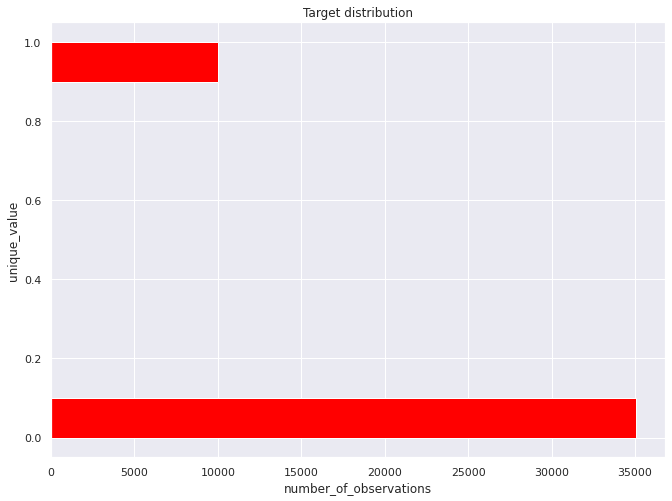

In [67]:
# Check the class balance:

ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [68]:
# Separate the input variable names by excluding the target:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [69]:
# Apply the function to replace NaN values:
table = fill_nan(data)

# Separate the target variable and input features
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [70]:
# Question 2. Make an interval estimate of the average age for the customers
# who delayed repayment at the 90% confidence level. Use the example from the
# article as reference, if needed. Also, use np.random.seed(0) as before. 
# What is the resulting interval estimate?

# Options
# 52.59 – 52.86
# 45.71 – 46.13 *
# 45.68 – 46.17
# 52.56 – 52.88

def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Make an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the ages of those who let a delay
churn = data[data['SeriousDlqin2yrs'] == 1]['age'].values
# Set the random seed for reproducibility
np.random.seed(0)
# Generate bootstrap samples and calculate the mean for each sample
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn, 1000)]
# Print the interval estimate for the sample means
print("Mean interval", stat_intervals(churn_mean_scores, 0.1))

Mean interval [45.71379414 46.12700479]


In [71]:
# Now, we will create a LogisticRegression model and use 
# class_weight='balanced' to make up for our unbalanced classes.

lr = LogisticRegression(random_state=5, class_weight='balanced')
# Let's try to find the best regularization coefficient, which is the 
# coefficient C for logistic regression. Then, we will have an optimal 
# model that is not overfit and is a good predictor of the target variable.

parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}
# In order to find the optimal value of C, let's apply stratified 5-fold 
# validation and look at the ROC AUC against different values of the parameter
# C. Use the StratifiedKFold function for this:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
# One of the important metrics of model quality is the Area Under the Curve 
# (AUC). ROC AUC varies from 0 to 1. The closer ROC AUC is to 1, the better 
# the quality of the classification model.

# Question 3. Perform a Grid Search with the scoring metric "roc_auc" for the
# parameter C. Which value of the parameter C is optimal?

# Options
# 0.0001
# 0.001  *
# 0.01
# 0.1
# 1
# 10

grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring='roc_auc', cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
# Question 4. Can we consider the best model stable? The model is stable if 
# the standard deviation on validation is less than 0.5%. Save the ROC AUC 
# value of the best model; it will be useful for the following tasks.

# Options
# Yes
# No  *

grid_search.cv_results_['std_test_score'][1]

0.008137559189742445

In [73]:
grid_search.best_score_

0.8089120626797153

In [74]:
# Question 5. Feature importance is defined by the absolute value of its
# corresponding coefficient. First, you need to normalize all of the feature
# values so that it will be valid to compare them. What is the most important
# feature for the best logistic regression model?

# Options
# age
# NumberOfTime30-59DaysPastDueNotWorse  *
# DebtRatio
# NumberOfTimes90DaysLate
# NumberOfTime60-89DaysPastDueNotWorse
# MonthlyIncome
# NumberOfDependents

lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame({
    'feat': independent_columns_names,
    'coef': lr.coef_.flatten().tolist()}
).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


In [75]:
# Calculate how much DebtRatio affects our prediction 
# using the softmax function. What is its value?

# Options
# 0.38
# -0.02
# 0.11  *
# 0.24

print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.1142637528306527


In [76]:
# Let's see how we can interpret the impact of our features. For this, 
# recalculate the logistic regression with absolute values, that is without 
# scaling. Next, modify the customer's age by adding 20 years, keeping the 
# other features unchanged. How many times will the chance that the customer 
# will not repay their debt increase? You can find an example 
# of the theoretical calculation here.

# Options
# -0.01
# 0.70
# 8.32
# 0.66

lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
lr.fit(X, y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.462333
3,NumberOfTimes90DaysLate,0.406610
4,NumberOfTime60-89DaysPastDueNotWorse,0.239780
6,NumberOfDependents,0.161204
2,DebtRatio,-0.000010
5,MonthlyIncome,-0.000011
0,age,-0.013315


In [77]:
# Initialize Random Forest with 100 trees and balance target classes
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42,
    class_weight='balanced'
)
# We will search for the best parameters among the following values:
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}
# Also, we will use the stratified k-fold validation again.
# You should still have the skf variable.

# Question 8. How much higher is the ROC AUC of the best random forest model than that of the best logistic regression on validation?
# Options
# 4%
# 3%
# 2%
# 1%

# code here

In [78]:
# Question 9. What feature has the weakest impact in the Random Forest model?

# Options
# age
# NumberOfTime30-59DaysPastDueNotWorse
# DebtRatio
# NumberOfTimes90DaysLate
# NumberOfTime60-89DaysPastDueNotWorse
# MonthlyIncome
# NumberOfDependents

# code here

In [79]:
# Question 10. What is the most significant advantage of using Logistic Regression versus Random Forest for this problem?

# Options
# Spent less time for model fitting;
# Fewer variables to iterate;
# Feature interpretability;
# Linear properties of the algorithm.

In [80]:
parameters = {
    'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9],
    'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]
}
# Question 11. Fit a bagging classifier with random_state=42.
# For the base classifiers, use 100 logistic regressors and use
# RandomizedSearchCV instead of GridSearchCV. It will take a lot 
# of time to iterate over all 54 variants, so set the maximum number of
# iterations for RandomizedSearchCV to 20. Don't forgetto set the parameters
# cv and random_state=1. What is the best ROC AUC you achieve?

# Options
# 80.75%
# 80.12%
# 79.62%
# 76.50%

# code here

In [81]:
# Question 12. Give an interpretation of the best parameters for bagging.
# Why are these values of max_features and max_samples the best?

# Options
# For bagging it's important to use as few features as possible;
# Bagging works better on small samples;
# Less correlation between single models;
# The higher the number of features, the lower the loss of information.